In [ ]:
!pip install tensorlayer
import tensorlayer
from tensorlayer.files import load_mpii_pose_dataset

     |████████████████████████████████| 368kB 5.9MB/s 
     |████████████████████████████████| 3.3MB 20.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1
  Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninstalled progressbar2-3.38.0


In [ ]:
import tarfile
import os
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/My Drive/Fall 2020/COS 429/COS 429 Shared/'

In [ ]:
tar_filename = "mpii_human_pose_v1.tar.gz"
tarfile.open(base_path + tar_filename, 'r').extractall(base_path)

In [ ]:
import zipfile
tar_filename_annotations = base_path + "mpii_human_pose_v1_u12_2.zip"
with zipfile.ZipFile(tar_filename_annotations) as zf:
    zf.extractall("./")

In [ ]:
from tensorlayer import logging
from tensorlayer.files.utils import (del_file, folder_exists, load_file_list, maybe_download_and_extract)

In [ ]:
extracted_filename = "mpii_human_pose_v1_u12_2"
extracted_filename2 = "images"
is_16_pos_only = True

path = "./"
# parse annotation, format see http://human-pose.mpi-inf.mpg.de/#download
import scipy.io as sio
logging.info("reading annotations from mat file ...")

ann_train_list = []
ann_test_list = []
img_train_list = []
img_test_list = []

def save_joints():
    # joint_data_fn = os.path.join(path, 'data.json')
    # fp = open(joint_data_fn, 'w')
    mat = sio.loadmat(os.path.join(path, extracted_filename, "mpii_human_pose_v1_u12_1.mat"))

    for _, (anno, train_flag) in enumerate(  # all images
            zip(mat['RELEASE']['annolist'][0, 0][0], mat['RELEASE']['img_train'][0, 0][0])):

        img_fn = anno['image']['name'][0, 0][0]
        train_flag = int(train_flag)

        # print(i, img_fn, train_flag) # DEBUG print all images

        if train_flag:
            img_train_list.append(img_fn)
            ann_train_list.append([])
        else:
            img_test_list.append(img_fn)
            ann_test_list.append([])

        head_rect = []
        if 'x1' in str(anno['annorect'].dtype):
            head_rect = zip(
                [x1[0, 0] for x1 in anno['annorect']['x1'][0]], [y1[0, 0] for y1 in anno['annorect']['y1'][0]],
                [x2[0, 0] for x2 in anno['annorect']['x2'][0]], [y2[0, 0] for y2 in anno['annorect']['y2'][0]]
            )
        else:
            head_rect = []  # TODO

        if 'annopoints' in str(anno['annorect'].dtype):
            annopoints = anno['annorect']['annopoints'][0]
            head_x1s = anno['annorect']['x1'][0]
            head_y1s = anno['annorect']['y1'][0]
            head_x2s = anno['annorect']['x2'][0]
            head_y2s = anno['annorect']['y2'][0]

            for annopoint, head_x1, head_y1, head_x2, head_y2 in zip(annopoints, head_x1s, head_y1s, head_x2s,
                                                                     head_y2s):
                # if annopoint != []:
                # if len(annopoint) != 0:
                if annopoint.size:
                    head_rect = [
                        float(head_x1[0, 0]),
                        float(head_y1[0, 0]),
                        float(head_x2[0, 0]),
                        float(head_y2[0, 0])
                    ]

                    # joint coordinates
                    annopoint = annopoint['point'][0, 0]
                    j_id = [str(j_i[0, 0]) for j_i in annopoint['id'][0]]
                    x = [x[0, 0] for x in annopoint['x'][0]]
                    y = [y[0, 0] for y in annopoint['y'][0]]
                    joint_pos = {}
                    for _j_id, (_x, _y) in zip(j_id, zip(x, y)):
                        joint_pos[int(_j_id)] = [float(_x), float(_y)]
                    # joint_pos = fix_wrong_joints(joint_pos)

                    # visibility list
                    if 'is_visible' in str(annopoint.dtype):
                        vis = [v[0] if v.size > 0 else [0] for v in annopoint['is_visible'][0]]
                        vis = dict([(k, int(v[0])) if len(v) > 0 else v for k, v in zip(j_id, vis)])
                    else:
                        vis = None

                    # if len(joint_pos) == 16:
                    if ((is_16_pos_only ==True) and (len(joint_pos) == 16)) or (is_16_pos_only == False):
                        # only use image with 16 key points / or use all
                        data = {
                            'filename': img_fn,
                            'train': train_flag,
                            'head_rect': head_rect,
                            'is_visible': vis,
                            'joint_pos': joint_pos
                        }
                        # print(json.dumps(data), file=fp)  # py3
                        if train_flag:
                            ann_train_list[-1].append(data)
                        else:
                            ann_test_list[-1].append(data)

save_joints()

## read images dir
logging.info("reading images list ...")
img_dir = os.path.join(path, extracted_filename2)
_img_list = load_file_list(path=os.path.join(path, extracted_filename2), regx='\\.jpg', printable=False)
# ann_list = json.load(open(os.path.join(path, 'data.json')))
for i, im in enumerate(img_train_list):
    if im not in _img_list:
        print('missing training image {} in {} (remove from img(ann)_train_list)'.format(im, img_dir))
        # img_train_list.remove(im)
        del img_train_list[i]
        del ann_train_list[i]
for i, im in enumerate(img_test_list):
    if im not in _img_list:
        print('missing testing image {} in {} (remove from img(ann)_test_list)'.format(im, img_dir))
        # img_test_list.remove(im)
        del img_train_list[i]
        del ann_train_list[i]

## check annotation and images
n_train_images = len(img_train_list)
n_test_images = len(img_test_list)
n_images = n_train_images + n_test_images
logging.info("n_images: {} n_train_images: {} n_test_images: {}".format(n_images, n_train_images, n_test_images))
n_train_ann = len(ann_train_list)
n_test_ann = len(ann_test_list)
n_ann = n_train_ann + n_test_ann
logging.info("n_ann: {} n_train_ann: {} n_test_ann: {}".format(n_ann, n_train_ann, n_test_ann))
n_train_people = len(sum(ann_train_list, []))
n_test_people = len(sum(ann_test_list, []))
n_people = n_train_people + n_test_people
logging.info("n_people: {} n_train_people: {} n_test_people: {}".format(n_people, n_train_people, n_test_people))
# add path to all image file name
for i, value in enumerate(img_train_list):
    img_train_list[i] = os.path.join(img_dir, value)
for i, value in enumerate(img_test_list):
    img_test_list[i] = os.path.join(img_dir, value)
# return img_train_list, ann_train_list, img_test_list, ann_test_list

[TL] reading annotations from mat file ...
[TL] reading images list ...
missing training image 040348287.jpg in ./images (remove from img(ann)_train_list)
missing training image 002878268.jpg in ./images (remove from img(ann)_train_list)
[TL] n_images: 24985 n_train_images: 18077 n_test_images: 6908
[TL] n_ann: 24985 n_train_ann: 18077 n_test_ann: 6908
[TL] n_people: 19919 n_train_people: 19919 n_test_people: 0


In [ ]:
print(ann_train_list[0][0])

{'filename': '015601864.jpg', 'train': 1, 'head_rect': [627.0, 100.0, 706.0, 198.0], 'is_visible': {'6': 0, '7': 1, '8': 0, '9': 0, '0': 1, '1': 1, '2': 1, '3': 0, '4': 1, '5': 1, '10': 1, '11': 1, '12': 1, '13': 1, '14': 1, '15': 1}, 'joint_pos': {6: [610.0, 187.0], 7: [647.0, 176.0], 8: [637.0201, 189.8183], 9: [695.9799, 108.1817], 0: [620.0, 394.0], 1: [616.0, 269.0], 2: [573.0, 185.0], 3: [647.0, 188.0], 4: [661.0, 221.0], 5: [656.0, 231.0], 10: [606.0, 217.0], 11: [553.0, 161.0], 12: [601.0, 167.0], 13: [692.0, 185.0], 14: [693.0, 240.0], 15: [688.0, 313.0]}}


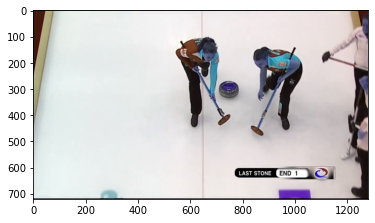

In [ ]:
import cv2
import matplotlib.pyplot as plt
im = cv2.imread(os.path.join(path, img_train_list[0]))
plt.imshow(im)

In [ ]:
(img_train_list[0])

'./images\\015601864.jpg'